In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import matplotlib.colors as mcolors
from copy import deepcopy


from imph.inputs.noisy_ring import CircleSimulator

from imph.filtrations.numpy.alphaDTML import AlphaDTMLayer

from imph.vectorizations.numpy.TOPK import TOPKLayers
from imph.vectorizations.numpy.vectorizations import PersistenceImages, PersistenceLandscapes


from imph.fisher.plot_fisher_stats import plotContours, plotSummaryDerivativeHists, plotConvergence
from imph.fisher.imnn import IMNNLayer, MopedLayer, ExtraDimLayer

from imph.imph.pipeline import CirclePipeline

import imph
import importlib

## Importlibs

In [141]:
importlib.reload(imph.fisher.Fisher)
importlib.reload(imph.imph.pipeline)
importlib.reload(imph.inputs.input_simulator)
importlib.reload(imph.fisher.imnn)

from imph.inputs.noisy_ring import CircleSimulator

from imph.filtrations.numpy.alphaDTML import AlphaDTMLayer

from imph.vectorizations.numpy.TOPK import TOPKLayers
from imph.vectorizations.numpy.vectorizations import PersistenceImages, PersistenceLandscapes


from imph.fisher.plot_fisher_stats import plotContours, plotSummaryDerivativeHists
from imph.fisher.imnn import IMNNLayer, MopedLayer, ExtraDimLayer

from imph.imph.pipeline import CirclePipeline
from imph.inputs.input_simulator import FisherSimulator

## Initializing pipeline

In [125]:
topk_vec_layer = TOPKLayers(bdp_type = "bd", is_binned = True, num_bins = [25, 5], hom_dim_list = [0, 1], quantile = 0.95)
moped_layer = MopedLayer()

circle_pipeline = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 10000, n_d = 10000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.1, 0.02]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = True),
                                 vecLayer = topk_vec_layer, \
                                 fisherLayer = moped_layer, find_derivative = [True, True])

In [126]:
circle_pipeline.run_pipeline()
fisher = circle_pipeline.fisher
fisher.FMnp, fisher.fractional_bias

100%|██████████| 10000/10000 [01:12<00:00, 138.16it/s]


<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[3768.40155142,  348.1805325 ],
       [ 348.1805325 , 4862.91270459]])>

In [2]:
circle_pipeline_validation = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 1000, n_d = 1000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.1, 0.02]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = True),
                                 vecLayer = topk_vec_layer, \
                                 fisherLayer = moped_layer, find_derivative = [True, True])

NameError: name 'CirclePipeline' is not defined

In [129]:
circle_pipeline_validation.run_pipeline()
fisher = circle_pipeline_validation.fisher
fisher.FMnp, fisher.fractional_bias

100%|██████████| 10000/10000 [01:10<00:00, 142.31it/s]


<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[3644.12030938,  401.67822788],
       [ 401.67822788, 4775.330367  ]])>

### Benchmarking

In [134]:
circle_pipeline_validation.collect_benchmarks()
fisher = circle_pipeline_validation.benchmarks['SortedMOPED']
fisher.FMnp, fisher.fractional_bias

(array([3902.1 ,   69.97,   69.97, 6087.73], dtype=float32),
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.00416365, 0.02068974])>)

In [135]:
fisher = circle_pipeline_validation.benchmarks['MeanVariance']
fisher.FMnp, fisher.fractional_bias

(array([ 2.70822e+03, -2.24000e+00, -2.24000e+00,  1.58717e+03],
       dtype=float32),
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.00250675, 0.01991275])>)

## Pipeline plots

### Input plot

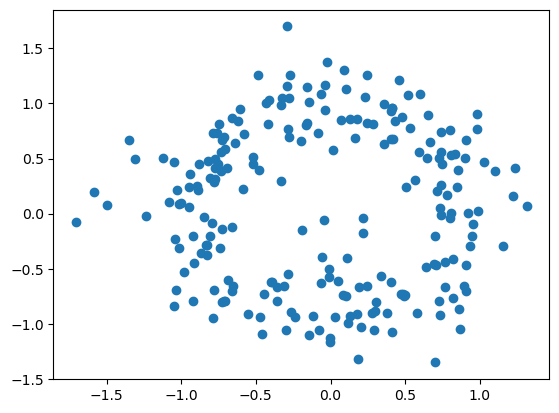

In [5]:
sample_pc = circle_pipeline.all_pts[0][0].numpy()
plt.scatter(sample_pc[:, 0], sample_pc[:, 1])
plt.savefig("plots/circle/sample_input.png")

### PD plot

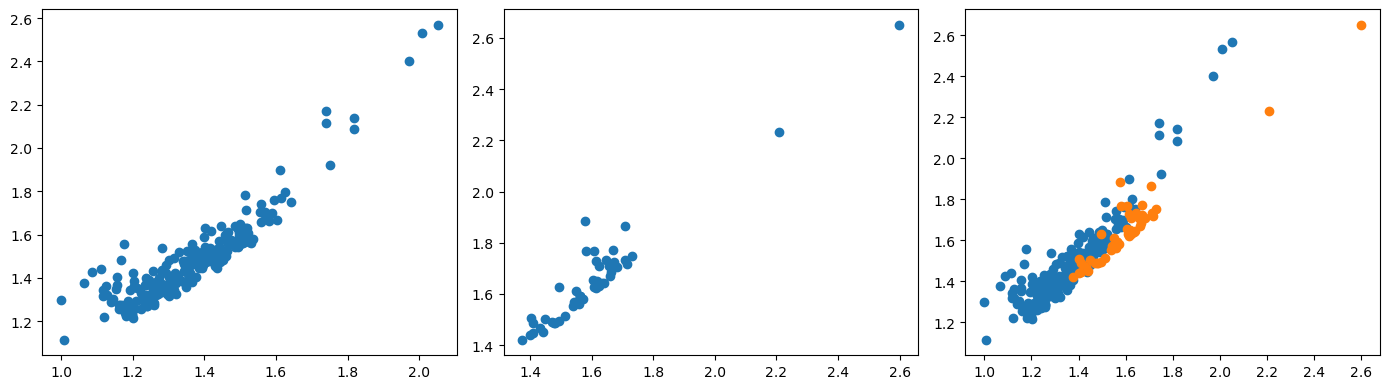

In [99]:
pd0 = circle_pipeline.all_simplex_trees[0][0].persistence_intervals_in_dimension(0)
pd1 = circle_pipeline.all_simplex_trees[0][0].persistence_intervals_in_dimension(1)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))  
axes[0].scatter(pd0[:, 0], pd0[: ,1])
axes[1].scatter(pd1[:, 0], pd1[: ,1])

axes[2].scatter(pd0[:, 0], pd0[: ,1])
axes[2].scatter(pd1[:, 0], pd1[: ,1])

plt.tight_layout()

## Top-k plot

In [1]:
ntot = circle_pipeline.inp_sim.ntot
def getFish(topks_new):
    bins = [np.maximum(2, topks_new[0]//20), 4]  
    # print(topks_new)
    fish = circle_pipeline.vectorize_and_fisher(\
            TopKBinned(topks = topks_new, num_bins = bins, \
                       hom_dim_list = [0, 1]),\
            MopedFisherLayer())
    fishMatrix = fish.FMnp
    return fishMatrix[0], fishMatrix[-1], fish.lnDetF

NameError: name 'circle_pipeline' is not defined

In [7]:
k0r = np.linspace(5, ntot - 2, 10, dtype = np.int32)
k1r = np.linspace(5, 25, 10, dtype = np.int32)
fisher_dict = {}
for idx1 in tqdm(k1r):
    for idx0 in k0r:
        inds = (idx0, idx1)
        fisher_dict[inds] = getFish(inds)            

100%|██████████| 10/10 [10:03<00:00, 60.32s/it]


In [9]:
graph_list = []
def getTopK(tp):
    # print(tval)
    dic = {}
    for idx1 in k1r:
        lis = []
        for idx0 in k0r:
            inds = (idx0, idx1)
            lis.append(fisher_dict[inds][tp])
        dic[idx1] = lis
    return dic

for idx in range(3): 
    graph_list.append(getTopK(idx))

In [ ]:
def plotTopK(dic, ax, title, tval):
    for idx in k1r: 
        ax.plot(k0r, dic[idx], label = "k1 = " + str(idx))
        
    
    ax.set_xlabel('k0')
    ax.set_title(title)
    ax.set_ylabel('FI')

    ax.axhline(tval, linestyle = 'dashed', c = 'red', label = "theoretical", alpha = 0.7)

tfm = circle_pipeline.benchmarks['TFM']
log_tfi = np.log(np.linalg.det(tfm)) 
tfi_lis = [tfm[0,0], tfm[-1,-1], log_tfi]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))   
names = ['FI(r)', 'FI($\sigma$)', 'log_tfi']

for idx in range(3): 
    plotTopK(graph_list[idx], axes[idx], names[idx], tfi_lis[idx])
    
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc = 'lower right')
fig.suptitle("Top-k graphs for m = 0.5")
plt.tight_layout()
# plt.show()
plt.savefig('plots/circle/topk_graphs.png' , bbox_inches='tight')

## Fisher contours for parts of PD

### m = 0.5

In [71]:
circle_pipeline = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 10000, n_d = 10000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.01, 0.002]),\
                                 filtLayer = AlphaDTMLayer(m = 0.5, show_tqdm = True),
                                 vecLayer = TopKBinned(topks = [219, 25], num_bins = [10, 5], hom_dim_list = [0, 1]), \
                                 fisherLayer = MopedFisherLayer())
circle_pipeline.run_pipeline()

100%|██████████| 10000/10000 [01:08<00:00, 146.12it/s]


In [82]:
importlib.reload(imph.vectorizations.numpy.TOPK)
from imph.vectorizations.numpy.TOPK import TopKBD, TopKBinned

In [83]:
ntot = circle_pipeline.inp_sim.ntot
vec_pd0 = TopKBinned(topks = [ntot - 1], num_bins = [20], hom_dim_list = [0])
vec_b0 = TopKBinned(topks = [ntot - 1], num_bins = [20], hom_dim_list = [0], bd_type = "births")
vec_d0 = TopKBinned(topks = [ntot - 1], num_bins = [20], hom_dim_list = [0], bd_type = "deaths")
vec_pd1 = TopKBinned(topks = [25], num_bins = [5], hom_dim_list = [1])
vec_b1 = TopKBinned(topks = [25], num_bins = [5], hom_dim_list = [1], bd_type = "births")
vec_d1 = TopKBinned(topks = [25], num_bins = [5], hom_dim_list = [1], bd_type = "deaths")
vec_all = TopKBinned(topks = [219, 25], num_bins = [10, 5], hom_dim_list = [0, 1])
fisher_matrices = []
fisher_matrices = [circle_pipeline.vectorize_and_fisher(item, MopedFisherLayer()).FMnp \
                   for item in [vec_pd0, vec_b0, vec_d0, vec_pd1, vec_b1, vec_d1, vec_all]]
fisher_matrices.extend([
    circle_pipeline.benchmarks['TFM'].flatten(),
    circle_pipeline.benchmarks['MeanVariance'].FMnp])

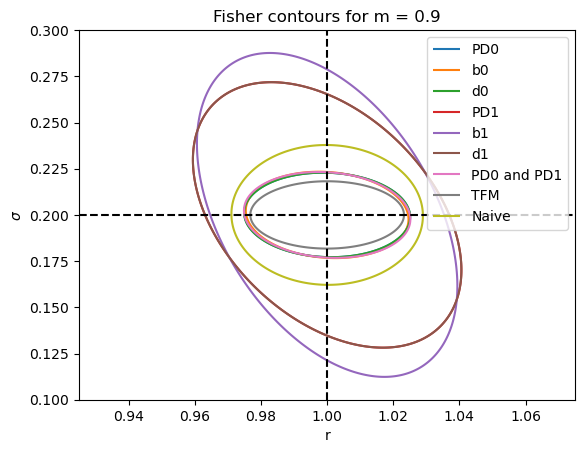

In [88]:
r, sigma = circle_pipeline.theta_fid
colors = list(mcolors.TABLEAU_COLORS)
names = ["PD0", "b0", "d0", "PD1", "b1", "d1", "PD0 and PD1", "TFM", "Naive"]
plotContours(fisher_matrices, names, r, sigma,\
             title = 'Fisher contours for m = ' + str(circle_pipeline.filtLayer.m),
             colors = colors,
             # colors = ['red', 'green', 'blue', 'orange', 'violet', 'black'],\
             xlabel = "r", ylabel = "$\sigma$", xlim = (0.925, 1.075), ylim = (0.1, 0.30),
            file_loc = "plots/circle/fc_parts_of_pd.png")

### m = 0.9

In [76]:
circle_pipeline = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 10000, n_d = 10000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.01, 0.002]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = True),
                                 vecLayer = TopKBinned(topks = [219, 25], num_bins = [10, 5], hom_dim_list = [0, 1]), \
                                 fisherLayer = MopedFisherLayer())
circle_pipeline.run_pipeline()

100%|██████████| 10000/10000 [01:02<00:00, 161.00it/s]


In [77]:
ntot = circle_pipeline.inp_sim.ntot
vec_pd0 = TopKBinned(topks = [ntot - 1], num_bins = [20], hom_dim_list = [0])
vec_pd1 = TopKBinned(topks = [25], num_bins = [5], hom_dim_list = [1])
vec_all = TopKBinned(topks = [219, 25], num_bins = [10, 5], hom_dim_list = [0, 1])
fisher_matrices = []
fisher_matrices = [circle_pipeline.vectorize_and_fisher(item, MopedFisherLayer()).FMnp \
                   for item in [vec_pd0, vec_pd1, vec_all]]
fisher_matrices.extend([
    circle_pipeline.benchmarks['TFM'].flatten(),
    circle_pipeline.benchmarks['MeanVariance'].FMnp])

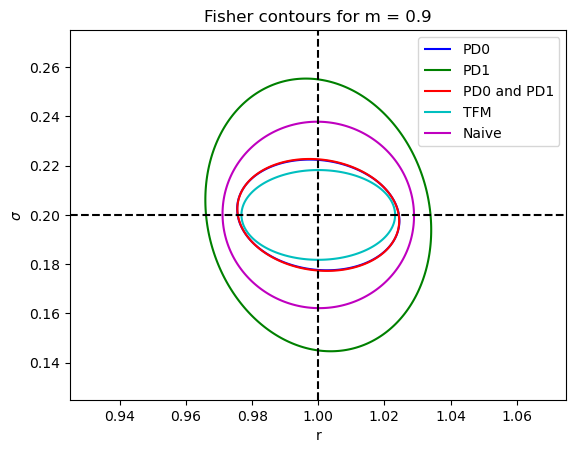

In [78]:
r, sigma = circle_pipeline.theta_fid
colors = list(mcolors.BASE_COLORS)
names = ["PD0", "PD1", "PD0 and PD1", "TFM", "Naive"]
plotContours(fisher_matrices, names, r, sigma,\
             title = 'Fisher contours for m = ' + str(circle_pipeline.filtLayer.m),
             colors = colors,
             # colors = ['red', 'green', 'blue', 'orange', 'violet', 'black'],\
             xlabel = "r", ylabel = "$\sigma$", xlim = (0.925, 1.075), ylim = (0.125, 0.275),
            file_loc = "plots/circle/fc_pd01.png")

## Fisher contours for different vectorizations

In [44]:
vec_fishers = {}

### Top-k

In [70]:
import imph
import importlib
importlib.reload(imph.fisher.Fisher)

<module 'imph.fisher.Fisher' from '/Users/karthikviswanathan/Desktop/TDA stuff/codes/fisherPH/versions/IMPHFinal/imph/fisher/Fisher.py'>

In [139]:
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(2)
])
topk_imnn_layer = IMNNLayer(comp, verbose = 0, epochs = 40, data_splits = [0.6, 0.3, 0.1], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)])
topk_vec_layer = TOPKLayers(bdp_type = "bd", hom_dim_list = [0, 1], quantile = 0.95)
fisher = circle_pipeline.vectorize_and_fisher(topk_vec_layer, topk_imnn_layer)
vec_fishers['topk_imnn'] = deepcopy(fisher)

In [140]:
fisher.fractional_bias.numpy(), fisher.FM

(array([0.05033661, 0.49655123]),
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[3729.692  ,  355.16003],
        [ 355.15942, 4590.2383 ]], dtype=float32)>)

In [135]:
fisher = circle_pipeline_validation.vectorize_and_fisher(topk_vec_layer, topk_imnn_layer)

In [136]:
fisher.fractional_bias.numpy(), fisher.FM

(array([0.03645652, 0.37875844]),
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[3745.477  ,  483.98624],
        [ 483.9869 , 4779.5317 ]], dtype=float32)>)

In [122]:
moped_layer = MopedLayer()
topk_vec_layer_binned = TOPKLayers(bdp_type = "bd", is_binned = True, num_bins = [25, 5], hom_dim_list = [0, 1], quantile = 0.95)
fisher_moped = circle_pipeline_validation.vectorize_and_fisher(topk_vec_layer_binned, moped_layer)
vec_fishers['topk_binned_moped'] = deepcopy(fisher_matrix_moped)

In [123]:
fisher_moped.FM, fisher_matrix_moped.fractional_bias.numpy()

(<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[3746.04124252,  469.74778168],
        [ 469.74778168, 4808.8684767 ]])>,
 array([0.01670085, 0.14884252]))

#### Plot for learning an optimal compression

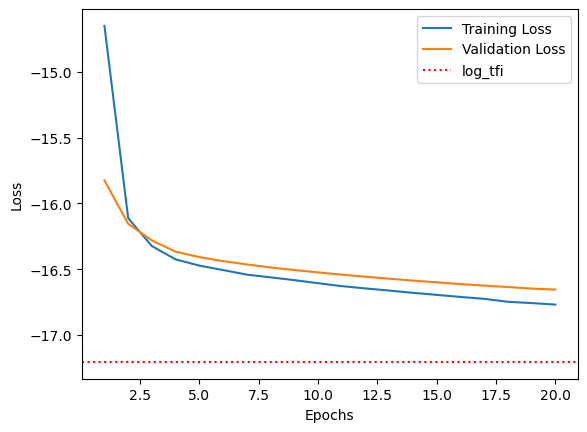

In [132]:
log_tfi = np.log(np.linalg.det(circle_pipeline.benchmarks['TFM']))
topk_imnn_layer.plot_loss(log_tfi = log_tfi)

### Persistence landscape

In [204]:
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2)
])
landscape_vec_layer = PersistenceLandscapes(resolutions = [32, 32], \
                                                      num_landscapes = [32, 8], hom_dim_list = [0, 1])
landscape_imnn_layer = IMNNLayer(comp, verbose = 0, epochs = 15)
fisher = circle_pipeline.vectorize_and_fisher(landscape_vec_layer, landscape_imnn_layer)
vec_fishers['landscape_imnn'] = deepcopy(fisher_matrix)

In [205]:
fisher.fractional_bias.numpy(), fisher.FM

(array([0.42178591, 0.44946995]),
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[3576.3005 ,  133.97798],
        [ 133.97787, 3988.8013 ]], dtype=float32)>)

In [144]:
fisher = circle_pipeline_validation.vectorize_and_fisher(landscape_vec_layer, landscape_imnn_layer)

In [145]:
fisher.fractional_bias.numpy(), fisher.FM

(array([0.30755648, 0.31931966]),
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[3536.1865  ,   87.83304 ],
        [  87.832565, 4099.719   ]], dtype=float32)>)

In [18]:
fisher_matrix.FM

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[3328.529  ,  413.31625],
       [ 413.31628, 3025.626  ]], dtype=float32)>

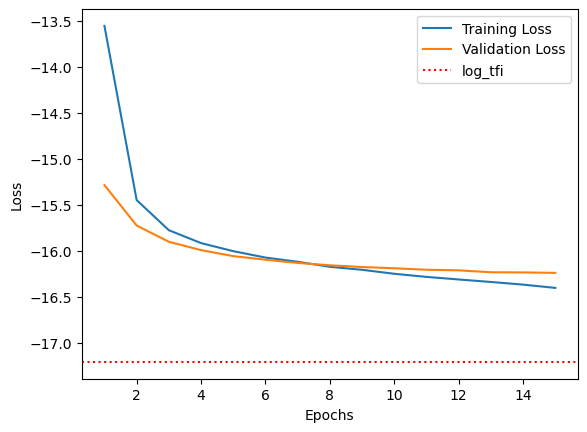

In [19]:
log_tfi = np.log(np.linalg.det(circle_pipeline.benchmarks['TFM']))
landscape_imnn_layer.plot_loss(log_tfi = log_tfi)

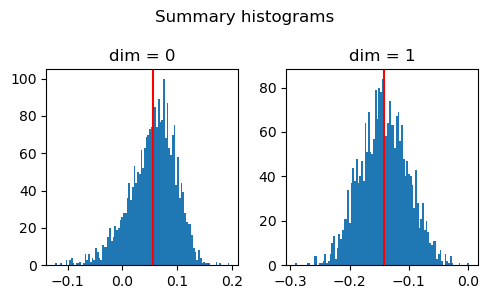

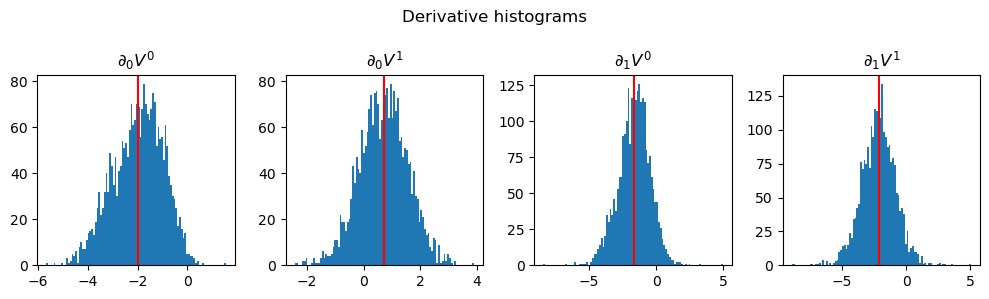

In [21]:
plotSummaryDerivativeHists(vec_fishers['landscape_imnn'])

### Persistence Images

In [ ]:
res = 24
model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 2))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides=2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(16, activation="relu", kernel_regularizer= tf.keras.regularizers.l2(l=0.1)),
        tf.keras.layers.Dense(2)
    ]
)
pi_vec_layer = PersistenceImages(resolutions = [[res, res], [res, res]], \
                                                      bandwidths = [3e-2, 5e-2], hom_dim_list = [0, 1])
pi_imnn_layer = IMNNLayer(model, verbose = 0, epochs = 40, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)])

circle_pipeline_pi = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 10000, n_d = 10000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.01, 0.002]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = True),
                                 vecLayer = pi_vec_layer, \
                                 fisherLayer = pi_imnn_layer, find_derivative = [True, True])
fisher = circle_pipeline_pi.run_pipeline()
fisher.show_fm_and_bias()

In [162]:
fisher = circle_pipeline_pi.fisher
fisher.show_fm_and_bias()

FM =  [3866.82  261.85  261.85 4864.05]
Fractional bias =  [0.15 0.14]


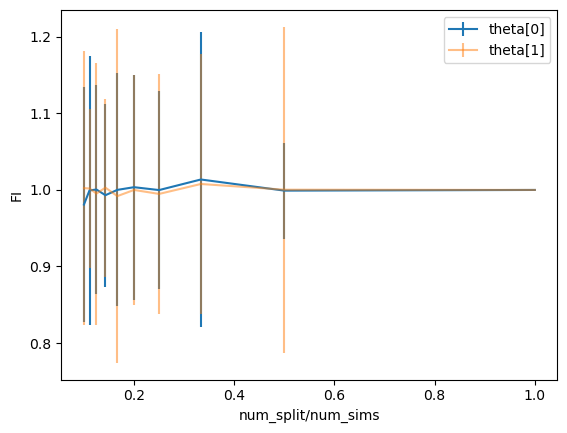

In [163]:
plotConvergence(fisher.summaries, fisher.δθ)

In [ ]:
circle_pipeline_temp = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 2000, n_d = 2000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta =  tf.constant([1., step]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = False),
                                 vecLayer = pi_vec_layer, \
                                 fisherLayer = pi_imnn_layer, find_derivative = [False, True])


fs_step = derivative_convergence_check(circle_pipeline_temp, step_list = np.linspace(0.01, 0.1, 10), \
                             param_idx = 0, seeds = [442, [913, 1011]])

#### Training

In [32]:
import importlib
import imph
importlib.reload(imph.vectorizations.numpy.vectorizations)
from imph.vectorizations.numpy.vectorizations import PersistenceImages

In [151]:
res = 24
model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 2))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides=2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(16, activation="relu", kernel_regularizer= tf.keras.regularizers.l2(l=0.1)),
        tf.keras.layers.Dense(2)
    ]
)
pi_vec_layer = PersistenceImages(resolutions = [[res, res], [res, res]], \
                                                      bandwidths = [3e-2, 5e-2], hom_dim_list = [0, 1])
pi_imnn_layer = IMNNLayer(model, verbose = 0, epochs = 40, data_splits = [0.6, 0.3, 0.1], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)])
fisher = circle_pipeline.vectorize_and_fisher(pi_vec_layer, pi_imnn_layer)

In [152]:
[item.max() for item in model.get_weights()]

[0.3201139, 0.04555815, 0.25356433, 0.3225095, 0.87276924, 7.4186714e-06]

In [153]:
fisher.show_fm_and_bias()

FM =  [25610.44  -565.54  -565.54  4910.33]
Fractional bias =  [0.14 0.04]


#### Testing

In [154]:
fisher = circle_pipeline_validation.vectorize_and_fisher(pi_vec_layer, pi_imnn_layer)
fisher.show_fm_and_bias()

FM =  [23497.94  -488.35  -488.35  4968.92]
Fractional bias =  [0.14 0.05]


FM =  [97227.64   582.92   582.93  3359.95]
Fractional bias =  [0.66 0.23]


In [144]:
fisher.fractional_bias.numpy(), fisher.FM

(array([1.6157944 , 0.07001512]),
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[47326.395 ,   585.3648],
        [  585.3723,  5053.8345]], dtype=float32)>)

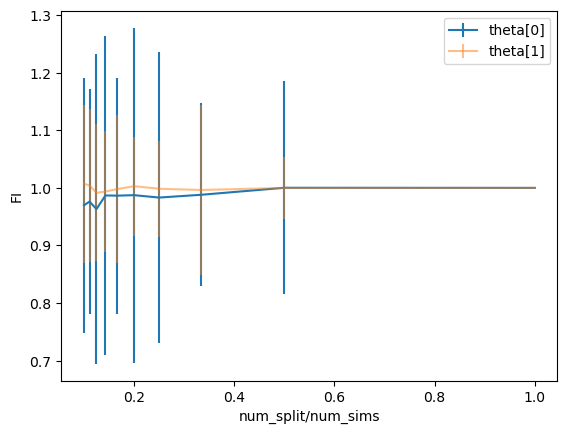

In [156]:
importlib.reload(imph.fisher.plot_fisher_stats)
imph.fisher.plot_fisher_stats.plotConvergence(fisher.summaries, fisher.δθ)

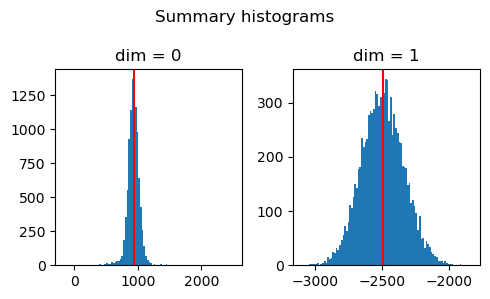

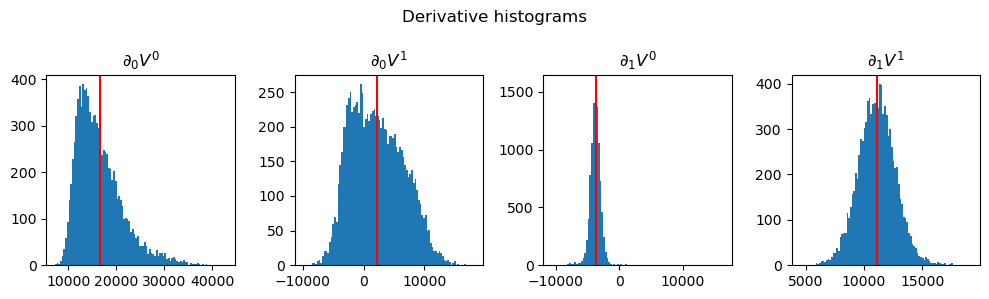

In [155]:
plotSummaryDerivativeHists(fisher)

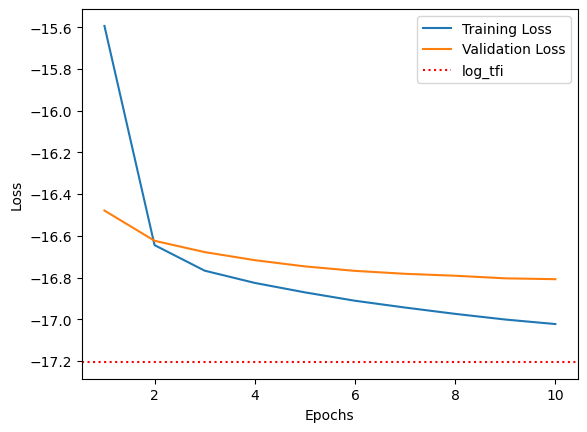

In [167]:
log_tfi = np.log(np.linalg.det(circle_pipeline.benchmarks['TFM']))
pi_imnn_layer.plot_loss(log_tfi = log_tfi)

#### Validating

In [109]:
importlib.reload(imph.imph.pipeline)
from imph.imph.pipeline import CirclePipeline

In [ ]:
circle_pipeline_validation = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 20000, n_d = 20000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.01, 0.002]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = True),
                                 vecLayer = topk_vec_layer, \
                                 fisherLayer = moped_layer)
circle_pipeline_validation.generate_input_data()
circle_pipeline_validation.filter_input_data()

In [29]:
fisher = circle_pipeline_validation.vectorize_and_fisher(pi_vec_layer, pi_imnn_layer)
fisher.FM

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[3973.937 ,  531.5092],
       [ 531.5093, 4148.6045]], dtype=float32)>

In [30]:
fisher = circle_pipeline_validation.vectorize_and_fisher(landscape_vec_layer, landscape_imnn_layer)
fisher.FM

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[3251.1626 ,  312.79636],
       [ 312.7964 , 3193.4578 ]], dtype=float32)>

In [ ]:
topk_vec_layer = TOPKLayers(bdp_type = "bd", hom_dim_list = [0, 1], quantile = 0.95)
fisher = circle_pipeline_validation.vectorize_and_fisher(topk_vec_layer, topk_imnn_layer)
fisher.FM

In [ ]:
moped_layer = MopedLayer()
topk_vec_layer_binned = TOPKLayers(bdp_type = "bd", is_binned = True, num_bins = [25, 5], \
                                   hom_dim_list = [0, 1], quantile = 0.95)
fisher = circle_pipeline_validation.vectorize_and_fisher(topk_vec_layer_binned, moped_layer)

In [742]:
inpVecLayer = pi_vec_layer
all_vecs = []; 
for sts in circle_pipeline_validation.all_simplex_trees:
    vecs = inpVecLayer.vectorize_simplex_trees(sts)
    all_vecs.append(vecs)

In [ ]:
comp_vecs = pi_imnn_layer.comp(tf.stack(all_vecs))

In [747]:
fisher = imph.fisher.Fisher.fisherFromVecs(comp_vecs, circle_pipeline_validation.delta_theta)
fisher.FMnp

array([4574.77,  322.22,  322.22, 5268.33], dtype=float32)

In [745]:
fisher = MopedFisherLayer().computeFisher(comp_vecs, circle_pipeline_validation.delta_theta)
fisher.FMnp

array([4525.4 ,  320.89,  320.89, 5335.87], dtype=float32)

### Fisher contours 

In [650]:
names = []
fisher_matrices = []
for key in vec_fishers.keys():
    vec_contours[key] = vec_fishers[key].FM.numpy()
    fisher_matrices.append(vec_fishers[key].FM.numpy())
    names.append(key)

fisher_matrices.extend([
    circle_pipeline.benchmarks['TFM'].flatten(),
    circle_pipeline.benchmarks['MeanVariance'].FMnp])
names.extend(['TFM', 'MeanVariance'])

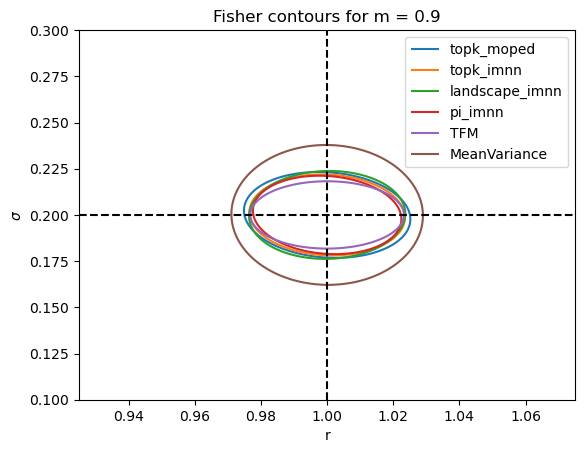

In [651]:
r, sigma = circle_pipeline.theta_fid
colors = list(mcolors.TABLEAU_COLORS)
plotContours(fisher_matrices, names, r, sigma,\
             title = 'Fisher contours for m = ' + str(circle_pipeline.filtLayer.m),
             colors = colors,
             # colors = ['red', 'green', 'blue', 'orange', 'violet', 'black'],\
             xlabel = "r", ylabel = "$\sigma$", xlim = (0.925, 1.075), ylim = (0.1, 0.30),
            file_loc = "plots/circle/fc_vectorizations.png")

## Fisher contours for different filtrations

In [ ]:
# TODO: Make sure that topk changes as 'm' changes. 
import matplotlib.colors as mcolors
m_range = np.linspace(0.1, 0.9, 9)
filtLayers = [AlphaDTMLayer(m = m) for m in m_range]
filtLayers.extend([AlphaFiltration(), RipsFiltration()])
circle_pipelines = [CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 4000, n_d = 4000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.01, 0.002]),\
                                 filtLayer = fl,
                                 vecLayer = TopKBinned(topks = [219, 25], num_bins = [10, 5], hom_dim_list = [0, 1]), \
                                 fisherLayer = MopedFisherLayer())
                                for fl in filtLayers]

fisher_matrices = []
for pl in tqdm(circle_pipelines):
    pl.run_pipeline(seeds = [42, 913])
    fisher_matrices.append(pl.fisher.FMnp)
    

In [43]:
fisher_matrices.extend([
    circle_pipelines[-1].benchmarks['TFM'].flatten(),
    circle_pipelines[-1].benchmarks['MeanVariance'].FMnp,
    circle_pipelines[-1].benchmarks['SortedMOPED'].FMnp])
names = ["m = " + str(np.round(m,1)) for m in m_range]
names.extend(["Alpha", "Rips", "TFM", "Naive", "Sorted"])

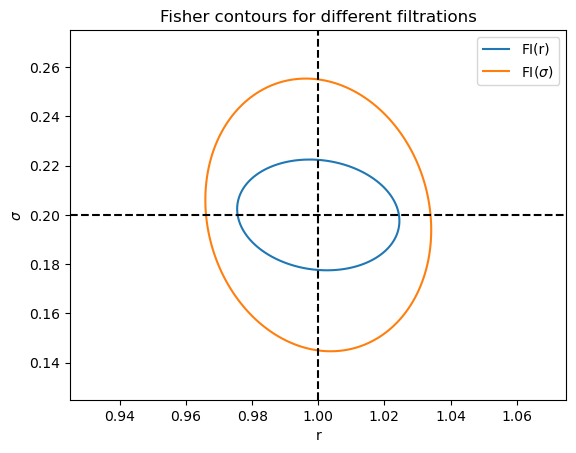

In [80]:
r, sigma = circle_pipeline.theta_fid
colors = list(mcolors.TABLEAU_COLORS)
colors.extend(list(mcolors.BASE_COLORS))
plotContours(fisher_matrices[:-3], names, r, sigma,\
             title = None,
             colors = colors,\
             xlabel = "r", ylabel = "$\sigma$", \
             xlim = (0.925, 1.075), ylim = (0.125, 0.275), 
            file_loc = "plots/circle/contours_for_diff_m.png")


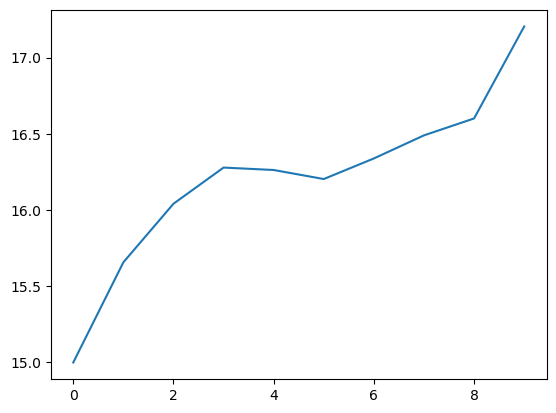

In [64]:
fms = fisher_matrices[:-5]
lnDetFs = [np.log(np.linalg.det(item.reshape(2,2)))for item in fms]
fisher_matrices_new = np.array(fisher_matrices)[:9]
# plt.plot(fisher_matrices_new[:, 3])
plt.plot(lnDetFs)

## FI vs nback plot

In [47]:
num_sims = 10000
nback_list = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90];
idx = 0;
fishers = []; mean_var_fishers = []; tfms = [];
circle_pipelines = [[] for _ in range(len(nback_list))]
for nback in tqdm(nback_list):
    circle_pipelines[idx] = CirclePipeline(ncirc= 200, nback = nback, bgmAvg = 1., n_s = num_sims, n_d = num_sims, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.01, 0.002]),\
                                 filtLayer = AlphaDTMLayer(m = 0.5, show_tqdm = False),
                                 vecLayer = TOPKLayers(bdp_type = "bd", num_bins = [25,5], is_binned = True,\
                                                       hom_dim_list = [0, 1], quantile = 0.9), \
                                 fisherLayer = MopedLayer())
    circle_pipelines[idx].run_pipeline()
    fish = circle_pipelines[idx].fisher
    fishers.append(deepcopy(fish)); 
    tfms.append(circle_pipelines[idx].benchmarks['TFM'].flatten())
    fish_mean_var = circle_pipelines[idx].benchmarks['MeanVariance']
    mean_var_fishers.append(deepcopy(fish_mean_var))    

100%|██████████| 10/10 [49:45<00:00, 298.58s/it]


In [48]:
tfms = np.array(tfms)
meanFisherMatrices = np.array([fish.FMnp for fish in mean_var_fishers])
fisherMatrices = np.array([fish.FMnp for fish in fishers])
tfis = np.array([np.log(np.linalg.det(tfm.reshape((2,2)))) for tfm in tfms])
meanFis = np.array([fish.lnDetF for fish in mean_var_fishers])
fis = np.array([fish.lnDetF for fish in fishers])

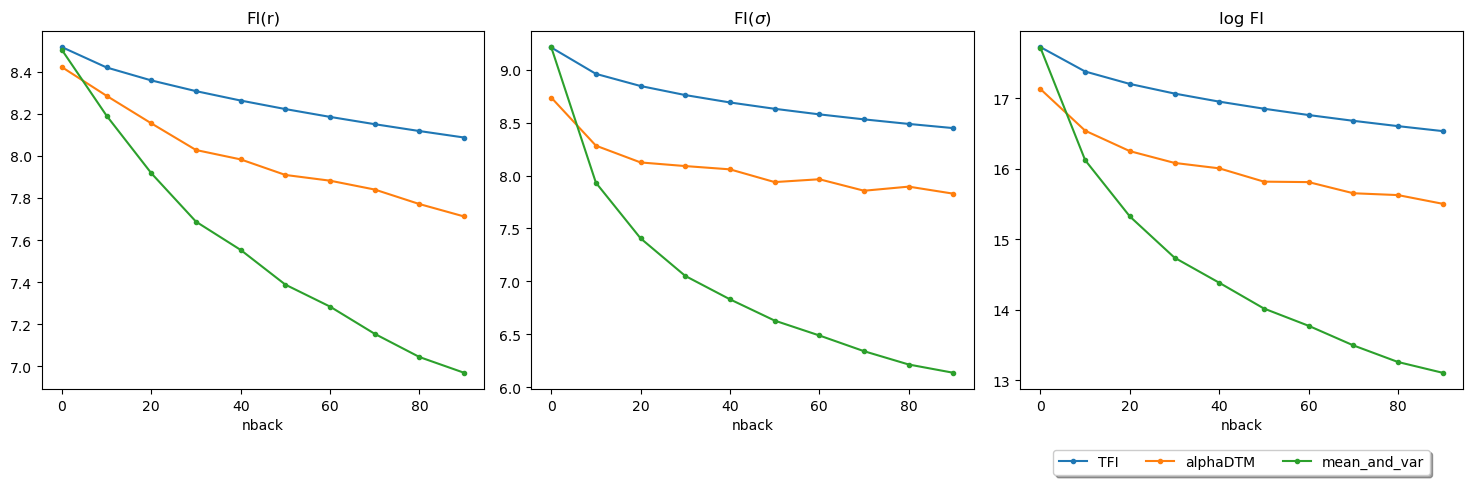

In [49]:
def plotArrays(y_vals_list, x_vals, ax, title, labels = ["TFI", "alphaDTM", "mean_and_var"], plot_log = False) :
    for idx, item in enumerate(y_vals_list):
        if(plot_log) : item = np.log(item)
        ax.plot(x_vals, item, label = labels[idx], marker = '.')
    ax.set_xlabel("nback") 
    ax.set_title(title)
    
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
plotArrays([tfms.T[0], fisherMatrices.T[0], meanFisherMatrices.T[0]] , nback_list, axes[0], "FI(r)", plot_log = True)
plotArrays([tfms.T[-1], fisherMatrices.T[-1], meanFisherMatrices.T[-1]] , nback_list, axes[1], "FI($\sigma$)", plot_log = True)
plotArrays([tfis, fis, meanFis] , nback_list, axes[2], "log FI")


lines, labels = fig.axes[-1].get_legend_handles_labels()

plt.legend(labels = labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), 
          fancybox=True, shadow=True, ncol=3)
plt.savefig("plots/circle/fi_for_diff_nback.png")
plt.tight_layout()

## Rough

### Importlib

In [70]:
importlib.reload(imph.imph.pipeline)
importlib.reload(imph.inputs.input_simulator)
from imph.imph.pipeline import CirclePipeline

### Ragged input for model?

In [177]:
topk_vec_layer = TOPKLayers(bdp_type = "bd", is_binned = True, num_bins = [25, 5], hom_dim_list = [0, 1], quantile = 0.95)
moped_layer = MopedLayer()

circle_pipeline_ragged = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 1000, n_d = 100, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.1, 0.02]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = True),
                                 vecLayer = topk_vec_layer, \
                                 fisherLayer = moped_layer, find_derivative = [True, True])
circle_pipeline_ragged.generate_input_data()

circle_pipeline_ragged.filter_input_data()
circle_pipeline_ragged.vectorize_all_simplex_trees()

100%|██████████| 100/100 [00:00<00:00, 140.66it/s]


In [ ]:
ragged_pts = circle_pipeline_ragged.all_vecs
# ragged_pts[0]
zz = tf.RaggedTensor.from_tensor(item) 
tf.concat(zz, axis = 2).shape

In [190]:
stack_ragged(ragged_pts).shape

TensorShape([5, None, 60])

In [ ]:
import tensorflow as tf

def stack_ragged(tensors):
    values = tf.concat(tensors, axis=0)
    lens = tf.stack([tf.shape(t, out_type=tf.int64)[0] for t in tensors])
    return tf.RaggedTensor.from_row_lengths(values, lens)
ragged_pts_T = tf.einsum("ij...->ji...", stack_ragged(ragged_pts))

### Effect of step size

#### MOPED

##### Larger example

In [31]:
fishers_step = []
fracs = np.linspace(0.05, 0.15, 5)
for frac in tqdm(fracs):
    topk_vec_layer = TOPKLayers(bdp_type = "bd", is_binned = True, num_bins = [25, 5], hom_dim_list = [0, 1], quantile = 0.95)
    moped_layer = MopedLayer()   
    circle_pipeline_temp = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 400, n_d = 400, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = frac * tf.constant([1., 0.2]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = False),
                                 vecLayer = topk_vec_layer, \
                                 fisherLayer = moped_layer)
    circle_pipeline_temp.run_pipeline(seeds = [42, [913, 1011]])
    print(frac, circle_pipeline_temp.fisher.FM.numpy().flatten())
    fishers_step.append(deepcopy(circle_pipeline_temp.fisher))

 20%|██        | 1/5 [00:13<00:55, 13.81s/it]

0.05 [2502.99854412 -153.17136723 -153.17136723 2155.30945139]


 40%|████      | 2/5 [00:26<00:40, 13.36s/it]

0.075 [2497.20050075 -110.46735484 -110.46735484 2381.00177142]


 60%|██████    | 3/5 [00:39<00:26, 13.10s/it]

0.1 [2470.12247535  -87.10396631  -87.10396631 2455.15819653]


 80%|████████  | 4/5 [00:53<00:13, 13.23s/it]

0.125 [2484.87176488  -68.49238018  -68.49238018 2553.1605121 ]


100%|██████████| 5/5 [01:06<00:00, 13.26s/it]

0.15 [2491.52836002  -61.03333745  -61.03333745 2491.89407787]


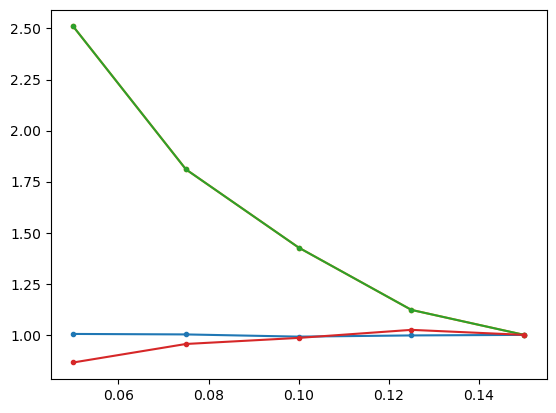

In [33]:
all_matrices = tf.stack([item.FM.numpy().flatten() for item in fishers_step])
for idx in range(4):
    plt.plot(fracs, all_matrices[:, idx]/ all_matrices[-1, idx], label = idx, marker = '.')
plt.show() 

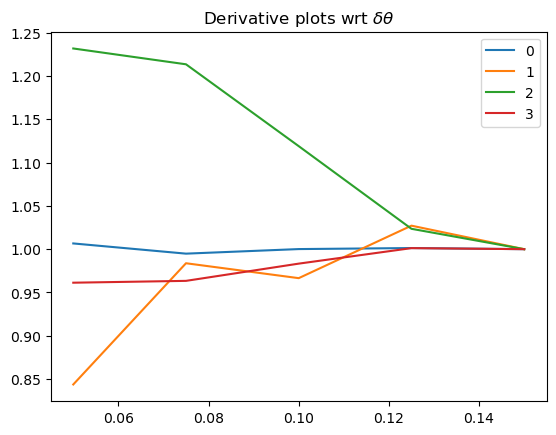

In [34]:
all_ders = tf.stack([item.ders.numpy().flatten() for item in fishers_step])
for idx in range(4):
    plt.plot(fracs, all_ders[:, idx]/ all_ders[-1, idx], label = idx)
plt.title("Derivative plots wrt $\delta \\theta $")
plt.legend()
plt.show()

##### Smaller example

In [24]:
importlib.reload(imph.imph.pipeline)
from imph.imph.pipeline import CirclePipeline

###### Finding step size for $r$

In [45]:
fishers_step = []
vecs_step = []
fracs = np.linspace(0.01, 0.2, 20)
# fracs = [0.001, 0.005, 0.01, 0.05, 0.1]
for frac in tqdm(fracs):
    topk_vec_layer = TOPKLayers(bdp_type = "bd", is_binned = True, num_bins = [25, 5], hom_dim_list = [0, 1], quantile = 0.95)
    moped_layer = MopedLayer()   
    circle_pipeline_temp = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 2000, n_d = 2000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = frac * tf.constant([1., 0.2]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = False),
                                 vecLayer = topk_vec_layer, \
                                 fisherLayer = moped_layer, find_derivative = [True, False])
    circle_pipeline_temp.run_pipeline(seeds = [42, [913, 1011]])
    # print(frac, circle_pipeline_temp.fisher.FM.numpy().flatten())
    fishers_step.append(deepcopy(circle_pipeline_temp.fisher))
    vecs_step.append(deepcopy(circle_pipeline_temp.all_vecs))

 25%|██▌       | 5/20 [03:12<09:33, 38.23s/it]

Decrease topk! Input shape =  30  topk =  31


 30%|███       | 6/20 [03:50<08:56, 38.34s/it]

Decrease topk! Input shape =  30  topk =  31


 40%|████      | 8/20 [05:06<07:39, 38.30s/it]

Decrease topk! Input shape =  30  topk =  31


 45%|████▌     | 9/20 [05:44<06:59, 38.18s/it]

Decrease topk! Input shape =  30  topk =  31


 50%|█████     | 10/20 [06:22<06:20, 38.01s/it]

Decrease topk! Input shape =  30  topk =  31


100%|██████████| 20/20 [12:42<00:00, 38.14s/it]


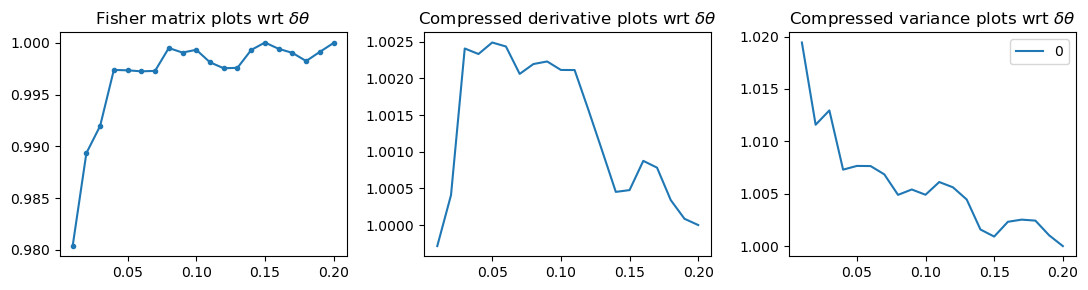

In [58]:
fig, axes  = plt.subplots(nrows = 1, ncols = 3, figsize=(11, 3))
all_matrices = tf.stack([item.FM.numpy().flatten() for item in fishers_step])
for idx in range(all_matrices[0].shape[0]):
    axes[0].plot(fracs, all_matrices[:, idx]/ all_matrices[-1, idx], label = [idx//2, idx%2], marker = '.')
    axes[0].set_title("Fisher matrix plots wrt $\delta \\theta $")
all_ders = tf.stack([item.ders.numpy().flatten() for item in fishers_step])
for idx in range(all_ders[0].shape[0]):
    axes[1].plot(fracs, all_ders[:, idx]/ all_ders[-1, idx], label = idx)
    axes[1].set_title("Compressed derivative plots wrt $\delta \\theta $")
    
all_ders = tf.stack([item.C.numpy().flatten()for item in fishers_step])
for idx in range(all_ders[0].shape[0]):
    axes[2].plot(fracs, all_ders[:, idx]/ all_ders[-1, idx], label = idx)
    axes[2].set_title("Compressed variance plots wrt $\delta \\theta $")
plt.legend()
plt.tight_layout()
plt.show() 

###### Finding step size for $\sigma$

In [62]:
fishers_step = []
vecs_step = []
step_list = np.linspace(0.001, 0.04, 40)
# fracs = [0.001, 0.005, 0.01, 0.05, 0.1]
for step in tqdm(step_list):
    topk_vec_layer = TOPKLayers(bdp_type = "bd", is_binned = True, num_bins = [25, 5], hom_dim_list = [0, 1], quantile = 0.95)
    moped_layer = MopedLayer()   
    circle_pipeline_temp = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 400, n_d = 400, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta =  tf.constant([1., step]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = False),
                                 vecLayer = topk_vec_layer, \
                                 fisherLayer = moped_layer, find_derivative = [False, True])
    circle_pipeline_temp.run_pipeline(seeds = [42, [913, 1011]])
    # print(frac, circle_pipeline_temp.fisher.FM.numpy().flatten())
    fishers_step.append(deepcopy(circle_pipeline_temp.fisher))
    vecs_step.append(deepcopy(circle_pipeline_temp.all_vecs))

100%|██████████| 40/40 [26:17<00:00, 39.43s/it]


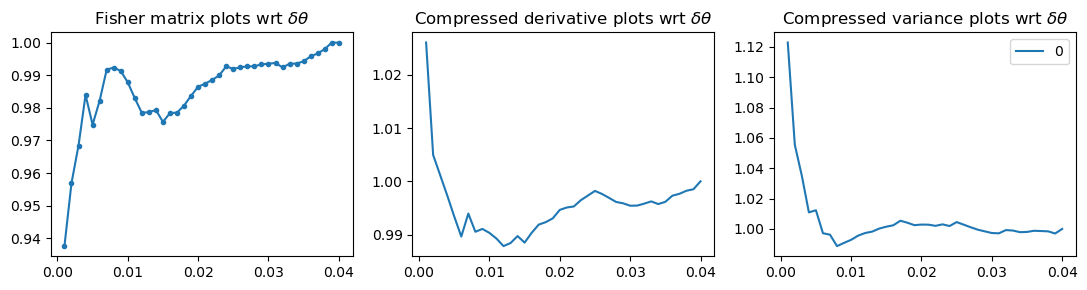

In [63]:
fig, axes  = plt.subplots(nrows = 1, ncols = 3, figsize=(11, 3))
all_matrices = tf.stack([item.FM.numpy().flatten() for item in fishers_step])
for idx in range(all_matrices[0].shape[0]):
    axes[0].plot(step_list, all_matrices[:, idx]/ all_matrices[-1, idx], label = [idx//2, idx%2], marker = '.')
    axes[0].set_title("Fisher matrix plots wrt $\delta \\theta $")
all_ders = tf.stack([item.ders.numpy().flatten() for item in fishers_step])
for idx in range(all_ders[0].shape[0]):
    axes[1].plot(step_list, all_ders[:, idx]/ all_ders[-1, idx], label = idx)
    axes[1].set_title("Compressed derivative plots wrt $\delta \\theta $")
    
all_ders = tf.stack([item.C.numpy().flatten()for item in fishers_step])
for idx in range(all_ders[0].shape[0]):
    axes[2].plot(step_list, all_ders[:, idx]/ all_ders[-1, idx], label = idx)
    axes[2].set_title("Compressed variance plots wrt $\delta \\theta $")
plt.legend()
plt.tight_layout()
plt.show() 

100%|██████████| 10/10 [01:21<00:00,  8.12s/it]


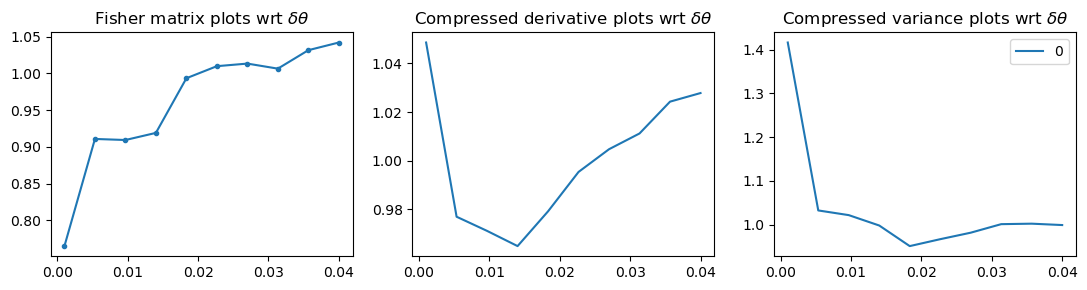

In [69]:
fishers_step = []
vecs_step = []
step_list = np.linspace(0.001, 0.04, 10)
# fracs = [0.001, 0.005, 0.01, 0.05, 0.1]
for step in tqdm(step_list):
    topk_vec_layer = TOPKLayers(bdp_type = "bd", is_binned = True, num_bins = [25, 5], hom_dim_list = [0, 1], quantile = 0.95)
    moped_layer = MopedLayer()   
    circle_pipeline_temp = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 400, n_d = 400, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta =  tf.constant([1., step]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = False),
                                 vecLayer = topk_vec_layer, \
                                 fisherLayer = moped_layer, find_derivative = [False, True])
    circle_pipeline_temp.run_pipeline(seeds = [42, [913, 1011]])
    # print(frac, circle_pipeline_temp.fisher.FM.numpy().flatten())
    fishers_step.append(deepcopy(circle_pipeline_temp.fisher))
    vecs_step.append(deepcopy(circle_pipeline_temp.all_vecs))
fig, axes  = plt.subplots(nrows = 1, ncols = 3, figsize=(11, 3))
all_matrices = tf.stack([item.FM.numpy().flatten() for item in fishers_step])
for idx in range(all_matrices[0].shape[0]):
    axes[0].plot(step_list, all_matrices[:, idx]/ np.median(all_matrices[:, idx]), label = [idx//2, idx%2], marker = '.')
    axes[0].set_title("Fisher matrix plots wrt $\delta \\theta $")
all_ders = tf.stack([item.ders.numpy().flatten() for item in fishers_step])
for idx in range(all_ders[0].shape[0]):
    axes[1].plot(step_list, all_ders[:, idx]/ np.median(all_ders[:, idx]), label = idx)
    axes[1].set_title("Compressed derivative plots wrt $\delta \\theta $")
    
all_ders = tf.stack([item.C.numpy().flatten()for item in fishers_step])
for idx in range(all_ders[0].shape[0]):
    axes[2].plot(step_list, all_ders[:, idx]/ np.median(all_ders[:, idx]), label = idx)
    axes[2].set_title("Compressed variance plots wrt $\delta \\theta $")
plt.legend()
plt.tight_layout()
plt.show() 

In [120]:
importlib.reload(imph)
importlib.reload(imph.imph.convergence_checks)
from imph.imph.convergence_checks import derivative_convergence_check

  0%|          | 0/10 [00:00<?, ?it/s]

Decrease topk! Input shape =  35  topk =  36


 50%|█████     | 5/10 [00:11<00:11,  2.35s/it]

Decrease topk! Input shape =  35  topk =  36


 60%|██████    | 6/10 [00:13<00:09,  2.32s/it]

Decrease topk! Input shape =  35  topk =  36
Decrease topk! Input shape =  35  topk =  36


 70%|███████   | 7/10 [00:16<00:06,  2.32s/it]

Decrease topk! Input shape =  35  topk =  36


 80%|████████  | 8/10 [00:18<00:04,  2.31s/it]

Decrease topk! Input shape =  35  topk =  36


 90%|█████████ | 9/10 [00:20<00:02,  2.30s/it]

Decrease topk! Input shape =  35  topk =  36


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


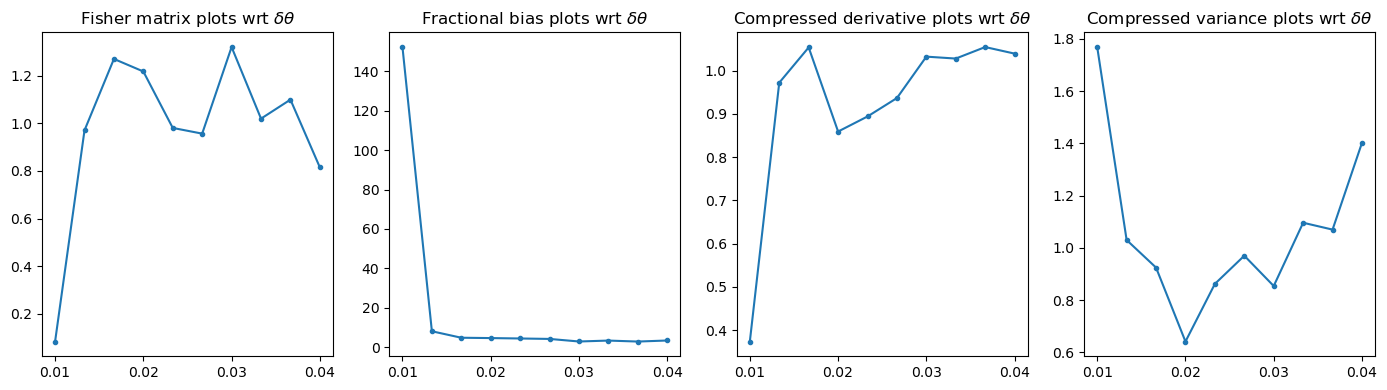

In [122]:
topk_vec_layer = TOPKLayers(bdp_type = "bd", is_binned = True, num_bins = [25, 5], hom_dim_list = [0, 1], quantile = 0.95)
moped_layer = MopedLayer()

circle_pipeline_temp = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 100, n_d = 100, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta =  tf.constant([1., step]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = False),
                                 vecLayer = topk_vec_layer, \
                                 fisherLayer = moped_layer, find_derivative = [False, True])


fs_step = derivative_convergence_check(circle_pipeline_temp, step_list = np.linspace(0.01, 0.04, 10), \
                             param_idx = 1, seeds = [442, [913, 1011]])

  0%|          | 0/10 [00:00<?, ?it/s]

Decrease topk! Input shape =  30  topk =  32


 10%|█         | 1/10 [00:39<05:54, 39.34s/it]

Decrease topk! Input shape =  29  topk =  32


 20%|██        | 2/10 [01:17<05:10, 38.83s/it]

Decrease topk! Input shape =  29  topk =  32


 30%|███       | 3/10 [01:58<04:38, 39.79s/it]

Decrease topk! Input shape =  30  topk =  32


 40%|████      | 4/10 [02:39<04:02, 40.35s/it]

Decrease topk! Input shape =  29  topk =  32


 50%|█████     | 5/10 [03:21<03:23, 40.61s/it]

Decrease topk! Input shape =  28  topk =  32


 60%|██████    | 6/10 [03:55<02:34, 38.68s/it]

Decrease topk! Input shape =  28  topk =  32


 70%|███████   | 7/10 [04:30<01:52, 37.38s/it]

Decrease topk! Input shape =  29  topk =  32


 80%|████████  | 8/10 [05:04<01:12, 36.26s/it]

Decrease topk! Input shape =  30  topk =  32


 90%|█████████ | 9/10 [05:38<00:35, 35.49s/it]

Decrease topk! Input shape =  30  topk =  32


100%|██████████| 10/10 [06:12<00:00, 37.29s/it]


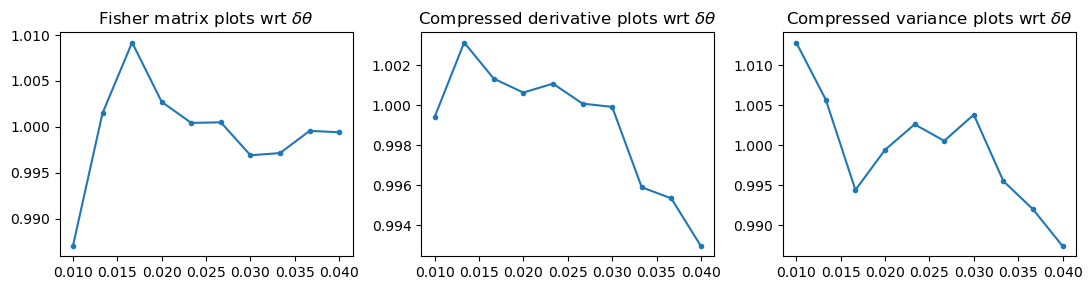

In [107]:
fs_step_2 = derivative_convergence_check(circle_pipeline_temp, step_list = np.linspace(0.01, 0.04, 10), \
                             param_idx = 1, seeds = [442, [9123, 12011]])

In [110]:
[print(a0.FM[0,0], a1.FM[0,0]) for (a0, a1) in zip(fs_step_2, fs_step)]

tf.Tensor(4232.279453506257, shape=(), dtype=float64) tf.Tensor(4290.470252932362, shape=(), dtype=float64)
tf.Tensor(4294.372765398011, shape=(), dtype=float64) tf.Tensor(4267.118247381345, shape=(), dtype=float64)
tf.Tensor(4327.4077708087125, shape=(), dtype=float64) tf.Tensor(4243.208253270834, shape=(), dtype=float64)
tf.Tensor(4299.676178476647, shape=(), dtype=float64) tf.Tensor(4282.198294926973, shape=(), dtype=float64)
tf.Tensor(4289.852312739033, shape=(), dtype=float64) tf.Tensor(4282.365859842125, shape=(), dtype=float64)
tf.Tensor(4290.106914585768, shape=(), dtype=float64) tf.Tensor(4270.314982386543, shape=(), dtype=float64)
tf.Tensor(4274.716240698423, shape=(), dtype=float64) tf.Tensor(4264.747914940424, shape=(), dtype=float64)
tf.Tensor(4275.747396048494, shape=(), dtype=float64) tf.Tensor(4268.080484865213, shape=(), dtype=float64)
tf.Tensor(4286.133651759668, shape=(), dtype=float64) tf.Tensor(4271.681197217886, shape=(), dtype=float64)
tf.Tensor(4285.469712715677

[None, None, None, None, None, None, None, None, None, None]

#### Persistence Image

In [ ]:
fishers_step_pi = []

# pi_vec_layer = PersistenceImages(resolutions = [[res, res], [res, res]], \
                              #                    bandwidths = [3e-2, 5e-2], hom_dim_list = [0, 1])
for frac in tqdm(fracs):
    circle_pipeline_temp = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 4000, n_d = 4000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = frac * tf.constant([1., 0.2]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = False),
                                 vecLayer = pi_vec_layer, \
                                 fisherLayer = pi_imnn_layer)
    circle_pipeline_temp.run_pipeline(seeds = [42, 913])
    print(frac, circle_pipeline_temp.fisher.FM.numpy().flatten())
    fishers_step_pi.append(deepcopy(circle_pipeline_temp.fisher))

In [ ]:
all_biases = tf.stack([item.fractional_bias.numpy().flatten() for item in fishers_step_pi])
for idx in range(2):
    plt.plot(fracs, all_biases[:, idx], label = [idx], marker = '.')
plt.title("Fisher matrix plots wrt $\delta \\theta $")
plt.legend()
plt.show() 

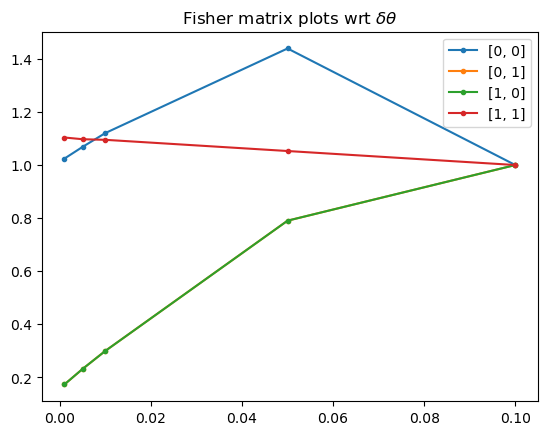

In [260]:
all_matrices = tf.stack([item.FM.numpy().flatten() for item in fishers_step_pi])
for idx in range(4):
    plt.plot(fracs, all_matrices[:, idx]/ all_matrices[-1, idx], label = [idx//2, idx%2], marker = '.')
plt.title("Fisher matrix plots wrt $\delta \\theta $")
plt.legend()
plt.show() 

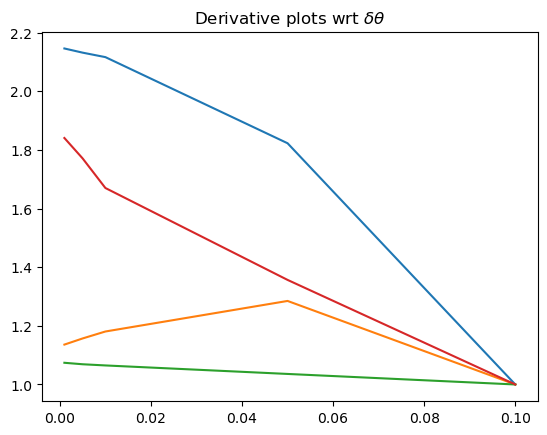

In [261]:
all_ders = tf.stack([item.ders.numpy().flatten() for item in fishers_step_pi])
for idx in range(4):
    plt.plot(fracs, all_ders[:, idx]/ all_ders[-1, idx], label = idx)
plt.title("Derivative plots wrt $\delta \\theta $")
plt.show()

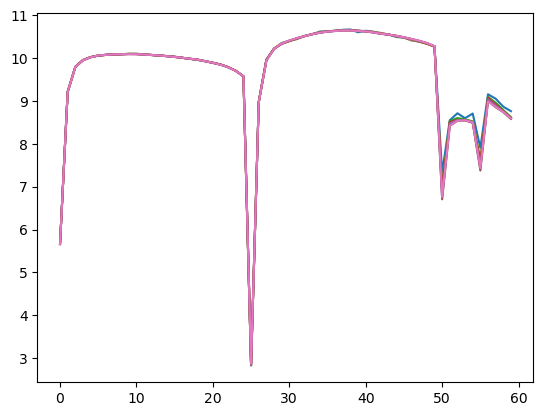

In [55]:
vecs = tf.stack(vecs_step)
fishers = [imph.fisher.Fisher.fisherFromVecs(item, fracs[idx] * tf.constant([1.])) for idx, item in enumerate(vecs)]
ders = tf.stack([fisher.ders for fisher in fishers])
for idx in [0]:
    plt.plot(ders[::3, idx, :].numpy().T)
    plt.show()

### Differentiability of persistence diagrams

In [711]:
all_sts = circle_pipeline.all_simplex_trees
ind = np.random.randint(1000)
st_f, st_r, st_sig =  all_sts[1][ind], all_sts[2][ind], all_sts[3][ind]
l1, l2, l3 = [set([tuple(z[0]) for z in item.get_skeleton(2)]) for item in [st_f, st_r, st_sig]]


In [712]:
l1 - l3

{(15, 37, 69),
 (15, 69),
 (15, 69, 97),
 (46, 66, 134),
 (46, 130, 134),
 (46, 134),
 (139, 162, 164),
 (162, 164),
 (162, 164, 178)}

In [713]:
l3 - l1

{(15, 37, 97),
 (37, 69, 97),
 (37, 97),
 (46, 66, 130),
 (66, 130),
 (66, 130, 134),
 (139, 162, 178),
 (139, 164, 178),
 (139, 178)}

In [738]:
circle_pipeline_rough = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 100, n_d = 100, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.005, 0.001]),\
                                 filtLayer = AlphaDTMLayer(m = 0.5, show_tqdm = True),
                                 vecLayer = TopKBinned(topks = [199, 25], num_bins = [10, 5], hom_dim_list = [0, 1]), \
                                 fisherLayer = MopedFisherLayer())
circle_pipeline_rough.run_pipeline()
def get_st(ptCloud):
        
        alpha = gudhi.AlphaComplex(points = ptCloud) # creating an AlphaComplex
        st = alpha.create_simplex_tree() 
        vert = np.array([s[0] for s in st.get_skeleton(0)])
        edges = [tuple(s[0]) for s in st.get_skeleton(1)\
                          if len(s[0]) == 2]
        
        triangles = [tuple(s[0]) for s in st.get_skeleton(2)\
                          if len(s[0]) == 3]
        
        return set(edges), set(triangles)
ind = np.random.randint(100)    
all_pts = circle_pipeline_rough.all_pts
pc_f, pc_r, pc_sig = all_pts[1][ind], all_pts[2][ind], all_pts[3][ind]



l1, l2, l3 = [get_st(item)[1] for item in [pc_f, pc_r, pc_sig]]


100%|██████████| 100/100 [00:00<00:00, 184.09it/s]


In [739]:
l1 - l2 , l2 - l1

({(110, 116, 174), (110, 116, 178)},
 {(48, 64, 142), (110, 174, 178), (116, 174, 178)})

In [740]:
l1 - l3, l3 - l1

({(124, 168, 179), (124, 179, 184)},
 {(48, 64, 142), (124, 168, 184), (168, 179, 184)})

In [762]:
tf.random.set_seed(42)
z1 = tf.random.normal(
    (10, 1),
    mean=1.0,
    stddev=1.0,
    dtype=tf.dtypes.float32,
    name=None
)
tf.random.set_seed(42)
z2 = tf.random.normal(
    (10, 1),
    mean=1.01,
    stddev=1.0,
    dtype=tf.dtypes.float32,
    name=None
)
tf.random.set_seed(42)
z3 = tf.random.normal(
    (10, 1),
    mean=1.02,
    stddev=1.0,
    dtype=tf.dtypes.float32,
    name=None
)
(z2 - z1)/0.01, (z3 - z1)/0.02


(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[0.99999905],
        [0.99999905],
        [0.99999905],
        [0.99999905],
        [0.99999905],
        [0.99999905],
        [0.99999905],
        [0.99999905],
        [0.9999752 ],
        [0.99999905]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[0.99999905],
        [0.99999905],
        [0.99999905],
        [0.99999905],
        [0.99999905],
        [0.99999905],
        [0.99999905],
        [0.99999905],
        [0.99999905],
        [0.99999905]], dtype=float32)>)

In [ ]:
class MopedLayer(FisherLayer):
    def __init__(self, name = "MOPEDFisher"):
        self.is_trained = False
        super().__init__(name)
        
    
    def computeFisher(self, all_vecs, delta_theta):
        if(not self.is_trained) :
            fisher = Fisher.fisherMOPED(all_vecs, delta_theta)
            self.compression_matrix = fisher.moped_compmat
            self.is_trained = True
            return fisher
        else:
            print("Hi")
            vecs = tf.matmul(all_vecs, self.compression_matrix)
            fisher = Fisher.fisherFromVecs(vecs, delta_theta)
            return fisher

### Persistence Images

In [354]:
importlib.reload(imph.vectorizations.numpy.vectorizations)
from imph.vectorizations.numpy.vectorizations import PersistenceImages

In [8]:
importlib.reload(imph.fisher.imnn)
from imph.fisher.imnn import IMNNLayer, ExtraDimLayer

In [12]:
res = 24
pi_vec_layer = PersistenceImages(resolutions = [[res, res], [res, res]], \
                                                      bandwidths = [3e-2, 5e-2], hom_dim_list = [0, 1])

circle_pipeline_pi = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 10000, n_d = 10000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.01, 0.002]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, show_tqdm = True),
                                 vecLayer = pi_vec_layer, \
                                 fisherLayer = MopedLayer(), find_derivative = [True, True])

In [ ]:
circle_pipeline_pi.run_pipeline()

In [14]:
vecs = tf.stack(circle_pipeline_pi.all_vecs)

In [114]:
importlib.reload(imph.fisher.imnn)
from imph.fisher.imnn import IMNNLayer, ExtraDimLayer

In [115]:
model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu", input_shape=(res, res, 2))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides=2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)


In [116]:
pi_imnn_layer = IMNNLayer(model, verbose = 1, epochs = 40, data_splits = [0.4, 0.2, 0.4], fisher_regularized = True, \
                         λ = 1., ϵ = 0.1, metrics = ["lnFI"])

In [ ]:
fisher = pi_imnn_layer.computeFisher(vecs, circle_pipeline_pi.delta_theta)

In [118]:
fisher.FM

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[713.8712 , 162.08582],
       [162.0858 , 972.2662 ]], dtype=float32)>

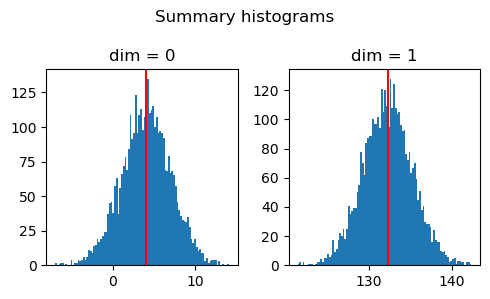

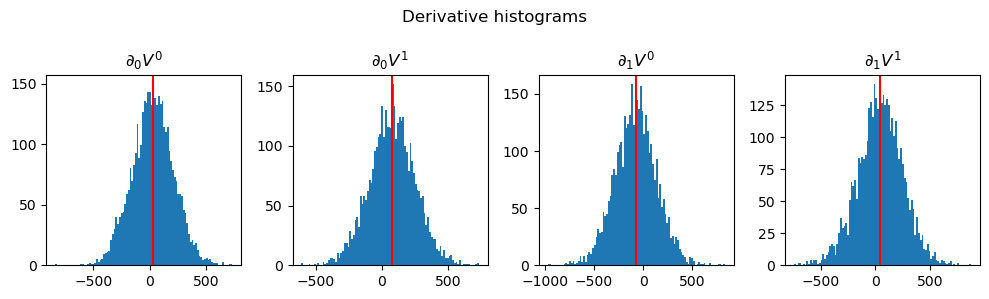

In [119]:
plotSummaryDerivativeHists(fisher)

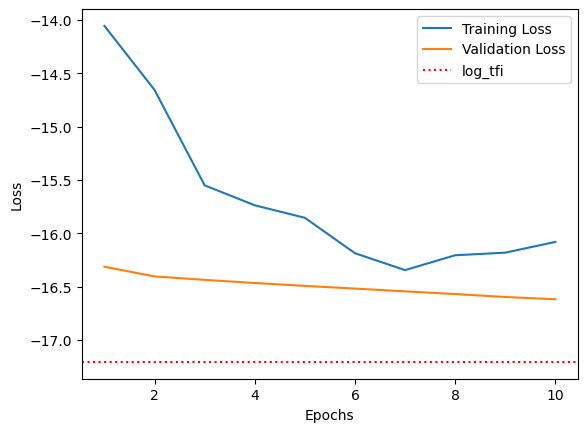

In [19]:
circle_pipeline_pi.collect_benchmarks()
log_tfi = np.log(np.linalg.det(circle_pipeline_pi.benchmarks['TFM']))
pi_imnn_layer.plot_loss(log_tfi = log_tfi)

In [335]:
sts = circle_pipeline.all_simplex_trees[0][:10]
vecs = pi_vec_layer.vectorize_simplex_trees(sts)
zz = pi_vec_layer.reshape_vec_to_images(vecs)

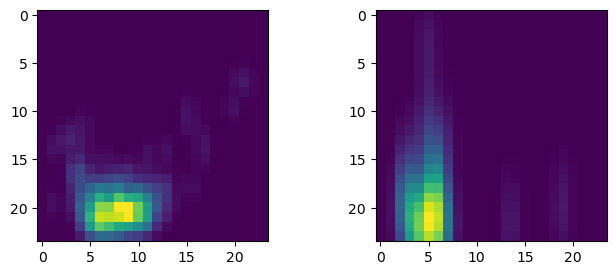

In [345]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axes[0].imshow(np.flip(zz[0][0], axis = 0))
axes[1].imshow(np.flip(zz[1][0], axis = 0))

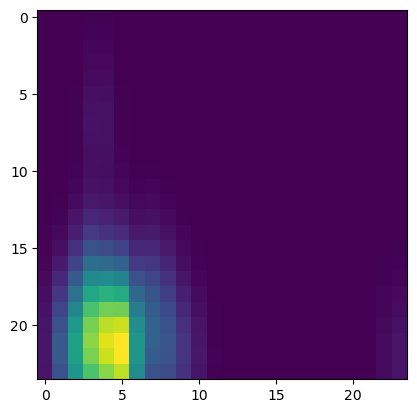

In [344]:
plt.imshow(np.flip(zz[1][7], axis = 0))

In [295]:
resolutions = np.array(pi_vec_layer.resolutions)
vecs.shape[-1], np.sum(resolutions * resolutions)

(512, 1024)